# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
! wget https://www.dropbox.com/s/6vdfw91q1b7gfq2/hseds-texts-2020.zip
! unzip -q hseds-texts-2020.zip 

--2020-12-20 22:16:30--  https://www.dropbox.com/s/6vdfw91q1b7gfq2/hseds-texts-2020.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6vdfw91q1b7gfq2/hseds-texts-2020.zip [following]
--2020-12-20 22:16:31--  https://www.dropbox.com/s/raw/6vdfw91q1b7gfq2/hseds-texts-2020.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf745a25bd2b3852df07d893485.dl.dropboxusercontent.com/cd/0/inline/BFfM1AFdhrPbXeJT8LayVEnKlFtkKzz49FEcYEVp1ZeQHegkjyHSi7TKOICKH4BDy3Ahv6w_Hj-eAJLGVygFh2lyw5Yf7c251C1N--5J6XbeVrRdrUz-0tfodWjnPbNNl2E/file# [following]
--2020-12-20 22:16:31--  https://ucf745a25bd2b3852df07d893485.dl.dropboxusercontent.com/cd/0/inline/BFfM1AFdhrPbXeJT8LayVEnKlFtkKzz49FEcYEVp1ZeQHegkjyHSi7TKOICKH4BDy3Ahv6w_Hj-eAJLGVygFh2l

In [2]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'

In [57]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [58]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_text(text):
    return ' '.join([word for word in word_tokenize(text.lower()) if word not in string.punctuation])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [60]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor

In [62]:
df_train['general'] = df_train['positive'] + ' ' + df_train['negative']
df_test['general'] = df_test['positive'] + ' ' + df_test['negative']

X_train, X_test, y_train, y_test = df_train['general'], df_test['general'], df_train['score'], df_test['score']

In [63]:
tfidf_vec = TfidfVectorizer()

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [64]:
np.random.seed(10)
from sklearn.metrics import mean_absolute_error

linreg = SGDRegressor()
linreg.fit(X_train_tfidf, y_train)

y_pred = linreg.predict(X_test_tfidf)
mean_absolute_error(y_test, y_pred)

0.9722410230017039

### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах.

In [11]:
import gensim
import pandas as pd
import numpy as np
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
def process_text_w2v(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

In [13]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'
df1 = pd.read_csv(PATH_TO_TRAIN_DATA)

df1['negative'] = df1['negative'].apply(process_text_w2v)
df1['positive'] = df1['positive'].apply(process_text_w2v)

In [14]:
from sklearn.model_selection import train_test_split
df_train1, df_test1 = train_test_split(df1)

df_train1['general'] = df_train1['positive'] + df_train1['negative']
df_test1['general'] = df_test1['positive'] + df_test1['negative']

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = df_train1['general'], df_test1['general'], df_train1['score'], df_test1['score']

In [15]:
# Обучили векторное представление слов
size = 500
w2v = gensim.models.Word2Vec(list(X_train_w2v), size=size, window=5)

In [16]:
# Пример

#w2v['hotel']

In [17]:
def document_vector_mean(doc):

    doc = [word for word in doc if word in w2v.wv.vocab]

    try:
      return np.mean(w2v[doc], axis=0)

    except:
      return np.zeros(size)

In [18]:
X_train_wv = list(X_train_w2v.apply(document_vector_mean))
X_test_wv = list(X_test_w2v.apply(document_vector_mean))

In [19]:
from sklearn.linear_model import LinearRegression

np.random.seed(10)
linreg = LinearRegression()

linreg.fit(X_train_wv, y_train_w2v)
y_pred = linreg.predict(X_test_wv)

mean_absolute_error(y_test_w2v, y_pred)

0.9957348915214186

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [20]:
idf_vectorizer = TfidfVectorizer()

# Взял создание idf отсюда:
# https://stackoverflow.com/questions/36756335/calculating-idf-using-tfidfvectorizer-from-sklearn-feature-extraction-text-tfidf
idf_vectorizer.fit_transform(X_train)
idf = idf_vectorizer.idf_
dic = dict(zip(idf_vectorizer.get_feature_names(), idf))

In [21]:
def document_vector_idf(doc):
  
  doc = [word for word in doc if word in w2v.wv.vocab]
  vec = np.zeros(size)

  for word in doc:
      try:
        vec += dic.get(word) * w2v[word] 
      except:
        vec += np.zeros(size)

  return vec

In [22]:
X_train_idf = list(X_train_w2v.apply(document_vector_idf))
X_test_idf = list(X_test_w2v.apply(document_vector_idf))

In [23]:
np.random.seed(10)
linreg = LinearRegression()

linreg.fit(X_train_idf, y_train_w2v)
y_pred = linreg.predict(X_test_idf)

mean_absolute_error(y_test_w2v, y_pred)

0.9455649387061414

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 

#### Сделайте выводы:

Чем больше размер Эмбеддинга, тем меньше средняя абсолютная ошибка (MAE). Такой результат вполне ожидаем, потому что в таком случае одно слово кодируется более высокой размерностью, то есть  - каждое слово включает больше смысла -> отзыв несёт больше смысла. 

In [24]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [25]:
def plot(size, mae_mean, mae_idf):

  plt.figure(figsize=(12, 8))
  plt.title('Сравнение усредненных Word2Vec и Word2Vec с учетом частоты idf')
  plt.xlabel('Размер эмбеддинга')
  plt.ylabel('MAE')
  plt.plot(size, mae_mean, 'k-', label='mean embeddings')
  plt.plot(size, mae_idf, 'r-', label='idf embeddings')
  plt.legend()

In [26]:
sizes = [size for size in range(100, 801, 100)]
mae_mean = []

for size in tqdm(sizes):
  w2v = gensim.models.Word2Vec(list(X_train_w2v), size=size, window=5)

  X_train_wv = list(X_train_w2v.apply(document_vector_mean))
  X_test_wv = list(X_test_w2v.apply(document_vector_mean))

  linreg = LinearRegression()

  linreg.fit(X_train_wv, y_train_w2v)
  y_pred = linreg.predict(X_test_wv)

  mae_mean.append(mean_absolute_error(y_test_w2v, y_pred))


In [27]:
sizes = [size for size in range(100, 801, 100)]
mae_idf = []

for size in tqdm(sizes):
  w2v = gensim.models.Word2Vec(list(X_train_w2v), size=size, window=5)

  X_train_idf = list(X_train_w2v.apply(document_vector_idf))
  X_test_idf = list(X_test_w2v.apply(document_vector_idf))

  linreg = LinearRegression()

  linreg.fit(X_train_idf, y_train_w2v)
  y_pred = linreg.predict(X_test_idf)

  mae_idf.append(mean_absolute_error(y_test_w2v, y_pred))

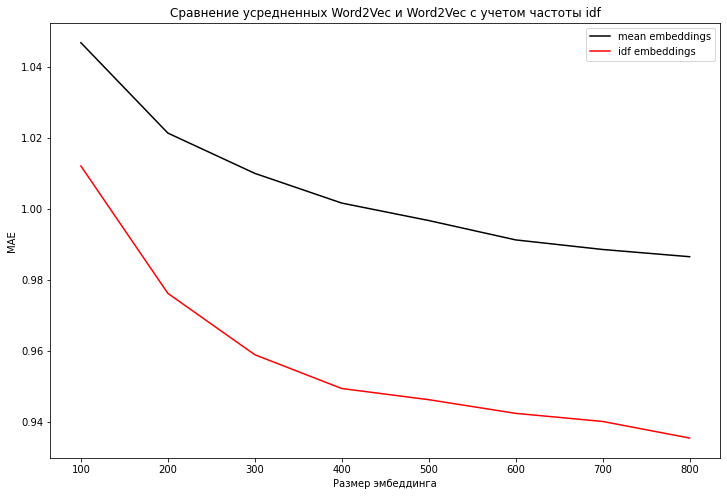

In [28]:
plot(sizes, mae_mean=mae_mean, mae_idf=mae_idf)

# Как видим, если учитываем вес слова, то качество всегда лучше

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы: 

FastText по своей механике по сути тот же Word2Vec, но изначально слово разбивается на части:

домашка -> ['до', 'дом', 'ома', 'маш', 'ашк', 'шка', 'ка']

Это позволяет получать более близкие векторы для слов с ошибками, либо для близких по смыслу слов (например, медведь и медвежонок). 

Однако, в нашем случае качество выросло совсем немного, поскольку это не какой-то научный текст / литературное произведение, а отзывы людей, написанные независимо. Соответственно и словарный запас здесь относительно невелик: сложно придумать много разных слов для описания отелей.

In [29]:
size = 300
fasttext = gensim.models.FastText(list(X_train_w2v), size=size, window=5)

In [30]:
def document_vector_ft(doc):

    doc = [word for word in doc if word in fasttext.wv.vocab]

    try:
      return np.mean(fasttext[doc], axis=0)

    except:
      return np.zeros(size)

In [31]:
X_train_ft = list(X_train_w2v.apply(document_vector_ft))
X_test_ft = list(X_test_w2v.apply(document_vector_ft))

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [33]:
# FastText размера 300
np.random.seed(10)
linreg = LinearRegression()

linreg.fit(X_train_ft, y_train_w2v)
y_pred = linreg.predict(X_test_ft)

mean_absolute_error(y_test_w2v, y_pred)

1.0087653858578476

In [34]:
size = 300
w2v = gensim.models.Word2Vec(list(X_train_w2v), size=size, window=5)

In [35]:
X_train_wv = list(X_train_w2v.apply(document_vector_mean))
X_test_wv = list(X_test_w2v.apply(document_vector_mean))

In [36]:
# Word2vec размера 300 (еще раз, для наглядности)

np.random.seed(10)
linreg = LinearRegression()

linreg.fit(X_train_wv, y_train_w2v)
y_pred = linreg.predict(X_test_wv)

mean_absolute_error(y_test_w2v, y_pred)

1.0079030441250203

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [37]:
import gensim
import pandas as pd
import numpy as np
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
import torch
from torch import nn
from torch.nn import functional as F

In [39]:
def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

In [40]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'
df = pd.read_csv(PATH_TO_TRAIN_DATA)

df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [41]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [42]:
df['general'] = df['negative'] + df['positive']

In [43]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [44]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, train_size=75000, test_size=25000)

In [45]:
# Удалим ненужные колонки
df_train.drop(columns=['review_id', 'positive', 'negative'], inplace=True)
df_test.drop(columns=['review_id', 'positive', 'negative'], inplace=True)

In [46]:
# Поменяем местами колонки
cols = df_train.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_train = df_train[cols]

cols_t = df_test.columns.tolist()
cols_t = cols_t[-1:] + cols_t[:-1]
df_test = df_test[cols_t]

In [47]:
from torch.nn.utils.rnn import pad_sequence
class ReviewsDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:50]) for seq in X], 
                           batch_first=True) # Паддим описания отеля
        self.y = torch.as_tensor(np.array(y))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [48]:
X_train, X_test, y_train, y_test = df_train['general'], df_test['general'], df_train['score'], df_test['score']

# Отдельно сделаем валидационный датасет, чтобы во время обучения прогонять не 25к элементов (долго), а всего 10к
X_val, y_val = df_test['general'][:10000], df_test['score'][:10000]
train_dataset = ReviewsDataset(X_train, y_train)
val_dataset = ReviewsDataset(X_val, y_val)
test_dataset = ReviewsDataset(X_test, y_test)

from torch.utils.data import DataLoader

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [49]:
import torch.nn as nn
# Код нейронной сети взять с Kaggle:
# https://www.kaggle.com/gabrielloye/simple-lstm-using-pytorch
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 1)
    
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [50]:
vocab_size = len(word2int) + 1
output_size = 1
embedding_dim = 450
hidden_dim = 50
n_layers = 2
device = torch.device("cuda")
criterion = nn.L1Loss() #MAE
model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.009)


print(model)

SentimentNet(
  (embedding): Embedding(34729, 450)
  (lstm): LSTM(450, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)


In [51]:
from tqdm.notebook import tqdm

In [52]:
epochs = 1
counter = 0
print_every = 5000
clip = 5

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in tqdm(train_loader):
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
  
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in tqdm(val_loader):
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        


Epoch: 1/1... Step: 5000... Loss: 0.746862... Val Loss: 1.273101



Epoch: 1/1... Step: 10000... Loss: 1.428136... Val Loss: 1.135886



Epoch: 1/1... Step: 15000... Loss: 0.678078... Val Loss: 1.111368



Epoch: 1/1... Step: 20000... Loss: 0.237479... Val Loss: 1.103257



Epoch: 1/1... Step: 25000... Loss: 0.729425... Val Loss: 1.046902



Epoch: 1/1... Step: 30000... Loss: 2.053753... Val Loss: 1.015606



Epoch: 1/1... Step: 35000... Loss: 2.213925... Val Loss: 1.014310



Epoch: 1/1... Step: 40000... Loss: 0.286945... Val Loss: 0.994071



Epoch: 1/1... Step: 45000... Loss: 1.045480... Val Loss: 0.991441



Epoch: 1/1... Step: 50000... Loss: 1.499575... Val Loss: 0.984927



Epoch: 1/1... Step: 55000... Loss: 1.031343... Val Loss: 0.971589



Epoch: 1/1... Step: 60000... Loss: 0.002186... Val Loss: 0.971318



Epoch: 1/1... Step: 65000... Loss: 0.031870... Val Loss: 0.975537



Epoch: 1/1... Step: 70000... Loss: 0.167065... Val Loss: 0.955875



Epoch: 1/1... Step: 75000... Loss: 1.011055... Val Loss: 0.949620



In [53]:
# На всем датасете:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in tqdm(test_loader):
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))


Test loss: 0.948


### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.